In [ ]:
from fastrenewables.tabular.learner import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.core import *
from fastrenewables.metrics import crps_for_quantiles
import pandas as pd
import zipfile
import zipfile, re, os
import numpy as np
from fastai.torch_basics import *
from fastai.metrics import rmse, mae
from fastai.tabular.all import *
import seaborn as sns
# import properscoring as ps
# import dcor
from fastrenewables.models.autoencoders import *
from fastrenewables.tabular.model import *
from fastrenewables.utils_pytorch import freeze, unfreeze_n_final_layer, print_requires_grad

In [ ]:
# !pip install fastdownload
# pip install dcor
# pip install properscoring

In [ ]:
# https://github.com/fastai/fastdownload/issues/16
# pip install "git+https://github.com/GenevieveBuckley/fastdownload/@fmod-exists-error"

In [ ]:
# from fastdownload import FastDownload

In [ ]:
# d = FastDownload()
# path = d.get('https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=1')

In [ ]:
def read_single_file(file_name):
    df = pd.read_hdf(file_name, key="powerdata")
    return df

In [ ]:
def extract_single_file(path_to_zip_file, directory_to_extract_to):
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(path=directory_to_extract_to)

In [ ]:
def extract_zip_in_folder(toFolder):
    for root, dirs, files in os.walk(toFolder):
        for filename in files:
            if re.search(r'\.zip$', filename):
                fileSpec = os.path.join(root, filename)
                extract_single_file(fileSpec, root)

In [ ]:
def get_wind_speed(x, y):
    z = np.sqrt(x ** 2 + y ** 2)
    return z

def get_wind_direction(x, y):
    z = get_wind_speed(x, y)
    phi = 2 * np.arctan(y / (x + z + 1e-16))
    return phi

In [ ]:
def read_csv(file_name):
    df = pd.read_csv(file_name, sep=",")
    df.TIMESTAMP = pd.to_datetime(df.TIMESTAMP, infer_datetime_format=True, utc=True)
    df = df.rename(columns={"TIMESTAMP": "TimeUTC", "TARGETVAR": "PowerGeneration", "ZONEID":"TaskID"})
    df.set_index("TimeUTC", inplace=True)
    
    return df

In [ ]:
def create_complete_task(file_name_task, file_name_solution=None):
    df = read_csv(file_name_task)
    
    cols = [("U10", "V10"),("U100", "V100")]
        
    for c in cols:
        ws = get_wind_speed(df[c[0]].values, df[c[1]].values)
        wd = get_wind_direction(df[c[0]].values, df[c[1]].values)
        w_height = "100" if "100" in c[0] else "10"
        
        df[f"WindSpeed{w_height}m"] = ws
        df[f"SinWindDirection{w_height}m"] = np.sin(wd)
        df[f"CosWindDirection{w_height}m"] = np.cos(wd)   
    
    df["WindSpeed10m_t_m1"] = df.WindSpeed10m.shift(1).fillna(method='bfill')
#     df["WindSpeed10m_t_p1"] = df.WindSpeed10m.shift(-1).fillna(method='ffill')
    
    df["WindSpeed100m_t_m1"] = df.WindSpeed100m.shift(1).fillna(method='bfill')
#     df["WindSpeed100m_t_p1"] = df.WindSpeed100m.shift(-1).fillna(method='ffill')
    
    if file_name_solution is not None:
        df_solution = read_csv(file_name_solution)
        df_solution = df_solution[df_solution.TaskID==df.TaskID[0]]
        
#         check if timestamps match
        if (df.index == df_solution.index).sum() == df.shape[0]:
            
            df["PowerGeneration"] = df_solution.PowerGeneration.values
        else:
            raise Warning("Timestamps do not match.")
    df.dropna(inplace=True)
    return df  

In [ ]:
def merge_dfs(first_list, second_list):
    dfs = []
    if len(first_list)!= len(second_list):
        raise ValueError("Different lenghts of list.")
        
    for idx in range(len(first_list)):
        df1, df2 = first_list[idx], second_list[idx]
        if df1.TaskID[0] != df2.TaskID[0]:
            raise ValueError("Not sorted correctly. Not matching task ids.")
        dfs.append(pd.concat([df1, df2], axis=0))
        
    return dfs

In [ ]:
def prepare_for_tasks(dfs, gefcom_task=1):
    
    start_date = pd.to_datetime("2012-10-01", utc=True) + pd.DateOffset(months=gefcom_task-1)
    end_date = last_day_of_month(start_date)
    
    dfs_train = []
    for df in dfs:
        mask = df.index < start_date
        dfs_train.append(df[mask])
        
    dfs_test = []
    for df in dfs:
        mask = (df.index >= start_date) & (df.index <= end_date)
        dfs_test.append(df[mask])

    return pd.concat(dfs_train, axis=0), pd.concat(dfs_test, axis=0)

In [ ]:
import datetime

def last_day_of_month(any_day):
    # this will never fail
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - datetime.timedelta(days=next_month.day)

In [ ]:
# uncomment if file is not yet downloaded

# !wget "https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip"
# extract_single_file("GEFCom2014.zip", "./")
# extract_single_file("GEFCom2014 Data/GEFCom2014-W_V2.zip", "./")
# extract_zip_in_folder("./Wind/")

In [ ]:
ls

'GEFCom2014 Data'/   GEFCom2014.zip.2     gefcom-janosch.ipynb
 GEFCom2014.zip      gefcom-Copy1.ipynb   preprocessing.py
 GEFCom2014.zip.1    gefcom.ipynb         Wind/


In [ ]:
files_task = !ls {"./Wind/Task\ 15/Task15_W_Zone1_10/*csv"}

In [ ]:
dfs_task = [create_complete_task(f) for f in files_task]
len(dfs_task)

10

In [ ]:
files_task_solution = !ls {"./Wind/Task\ 15/TaskExpVars15_W_Zone1_10/*csv"}
dfs_task_solution = [create_complete_task(f, './Wind/Solution to Task 15/solution15_W.csv') for f in files_task_solution]

In [ ]:
dfs = merge_dfs(dfs_task, dfs_task_solution)

In [ ]:
GEFCOM_TASK = 3

In [ ]:
df_train, df_test = prepare_for_tasks(dfs, gefcom_task=GEFCOM_TASK)

In [ ]:
df_train.head(2)

,TaskID,PowerGeneration,U10,V10,U100,V100,WindSpeed10m,SinWindDirection10m,CosWindDirection10m,WindSpeed100m,SinWindDirection100m,CosWindDirection100m,WindSpeed10m_t_m1,WindSpeed100m_t_m1
TimeUTC,,,,,,,,,,,,,,
2012-01-01 01:00:00+00:00,10,0.594361,1.655790,-4.649593,2.024257,-5.992232,4.935621,-0.942048,0.335477,6.324908,-0.947402,0.320045,4.935621,6.324908
2012-01-01 02:00:00+00:00,10,0.569679,2.178609,-4.184944,2.623141,-5.318086,4.718060,-0.887005,0.461759,5.929832,-0.896836,0.442363,4.935621,6.324908


In [ ]:
df_train.tail(2)

,TaskID,PowerGeneration,U10,V10,U100,V100,WindSpeed10m,SinWindDirection10m,CosWindDirection10m,WindSpeed100m,SinWindDirection100m,CosWindDirection100m,WindSpeed10m_t_m1,WindSpeed100m_t_m1
TimeUTC,,,,,,,,,,,,,,
2012-11-30 22:00:00+00:00,9,0.216178,4.802434,-0.467610,6.881132,-0.687509,4.825146,-0.096911,0.995293,6.915392,-0.099417,0.995046,4.120921,6.506149
2012-11-30 23:00:00+00:00,9,0.374596,5.232640,0.064078,7.361208,-0.004533,5.233032,0.012245,0.999925,7.361209,-0.000616,1.000000,4.825146,6.915392


In [ ]:
df_train.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
           dtype='int64', name='TimeUTC', length=80390)

In [ ]:
df_train.dtypes

TaskID                    int64
PowerGeneration         float64
U10                     float64
V10                     float64
U100                    float64
V100                    float64
WindSpeed10m            float64
SinWindDirection10m     float64
CosWindDirection10m     float64
WindSpeed100m           float64
SinWindDirection100m    float64
CosWindDirection100m    float64
WindSpeed10m_t_m1       float64
WindSpeed100m_t_m1      float64
dtype: object

In [ ]:
df_train.TaskID.unique()

array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [ ]:
cur_task_id = 1

In [ ]:
df_train_single_task, df_test_single_task = df_train[df_train.TaskID == cur_task_id], df_test[df_test.TaskID == cur_task_id]

In [ ]:
cat_names = []#["TaskID"]

cont_names = ['U10', 'V10', 'U100', 'V100',
       'WindSpeed10m', 'SinWindDirection10m', 'CosWindDirection10m',
       'WindSpeed100m', 'SinWindDirection100m', 'CosWindDirection100m',
       'WindSpeed10m_t_m1', 
       'WindSpeed100m_t_m1',
]

y_names = cont_names


In [ ]:
df_train_single_task.TaskID.unique()

array([1])

In [ ]:
dls = RenewableDataLoaders.from_df(df_train_single_task, 
                                   cat_names=cat_names, 
                                   cont_names=cont_names, 
                                   y_names=y_names,
                                   bs=24*30, 
                                   shuffle=True
                                  )

In [ ]:
dls.dataset.items.WindSpeed10m.describe()

count    6.432000e+03
mean     3.857818e-18
std      1.000078e+00
min     -1.993907e+00
25%     -7.839496e-01
50%     -2.017287e-01
75%      6.425150e-01
max      4.646842e+00
Name: WindSpeed10m, dtype: float64

In [ ]:
dls.train_ds.items.head(2)

,TaskID,PowerGeneration,U10,V10,U100,V100,WindSpeed10m,SinWindDirection10m,CosWindDirection10m,WindSpeed100m,SinWindDirection100m,CosWindDirection100m,WindSpeed10m_t_m1,WindSpeed100m_t_m1,MonthSin,MonthCos,DaySin,DayCos,HourSin,HourCos
TimeUTC,,,,,,,,,,,,,,,,,,,,
2012-04-09 08:00:00+00:00,1,0.598722,0.591816,1.667200,0.563383,1.641109,0.994299,1.205421,0.422416,1.000079,1.177074,0.383805,1.726372,1.440319,0.866025,-5.000000e-01,0.968077,-0.250653,0.866025,-0.500000
2012-09-07 02:00:00+00:00,1,0.968236,3.531055,0.711275,3.098195,0.647731,3.633996,0.262509,1.229532,3.241973,0.235654,1.219211,3.762432,3.308003,-1.000000,-1.836970e-16,0.988468,0.151428,0.500000,0.866025


In [ ]:
n_features = len(dls.train_ds.cont_names)
n_latent = 5
encoder_architecture = [n_features, n_features*4, n_features*2, n_features, n_latent]
decoder_architecture = encoder_architecture[::-1]
encoder_architecture, decoder_architecture


([12, 48, 24, 12, 5], [5, 12, 24, 48, 12])

In [ ]:
encoder, decoder = MultiLayerPerceptron(encoder_architecture), MultiLayerPerceptron(decoder_architecture)

In [ ]:
ae_model = Autoencoder(encoder, decoder)
# ae_model

In [ ]:
learner = RenewableLearner(dls, ae_model, metrics=rmse)

In [ ]:
def MSELossFlat(nn.Module):
    def __init__():
        super()
        
    def forward(y, yhat):
        return ((y.view(-1)-yhat.view(-1))**2).mean()

In [ ]:
# for i in range(5):
learner.fit(500)

epoch,train_loss,valid_loss,_rmse,time
0,0.966440,0.982801,0.991363,00:00
1,0.773765,0.915593,0.956866,00:00
2,0.627853,0.701183,0.837367,00:00
3,0.515617,0.403538,0.635246,00:00
4,0.425966,0.195995,0.442714,00:00
5,0.354160,0.107859,0.328418,00:00
6,0.296586,0.077247,0.277933,00:00
7,0.250676,0.062305,0.249609,00:00
8,0.213624,0.053028,0.230278,00:00
9,0.183476,0.045714,0.213809,00:00


In [ ]:
# learner.fit(50)

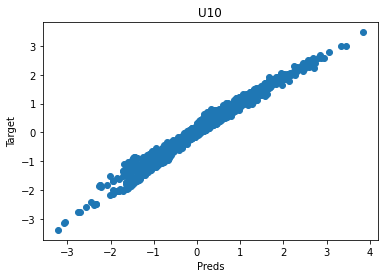

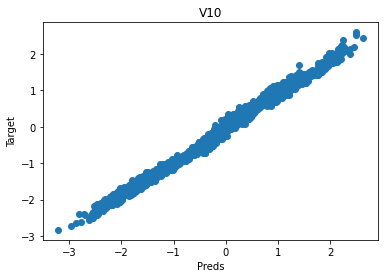

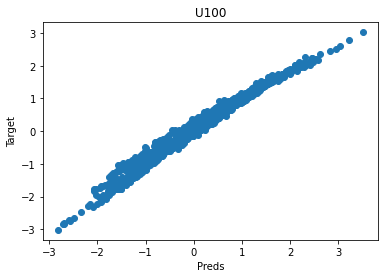

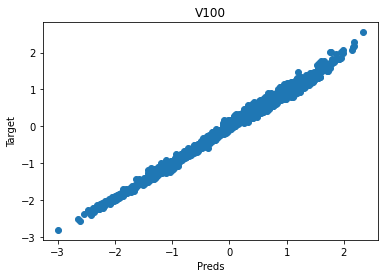

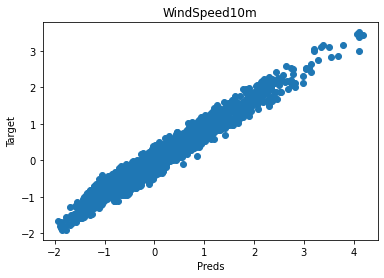

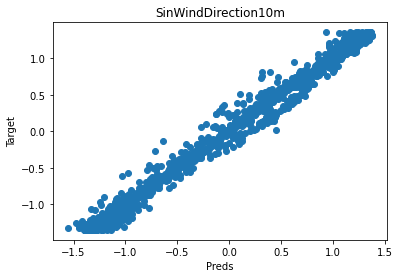

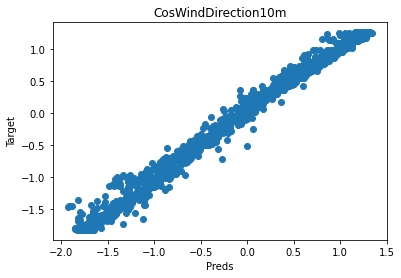

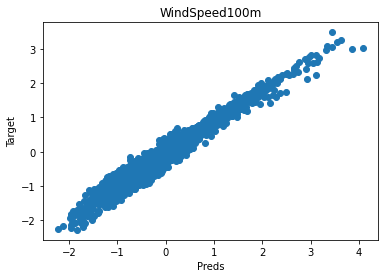

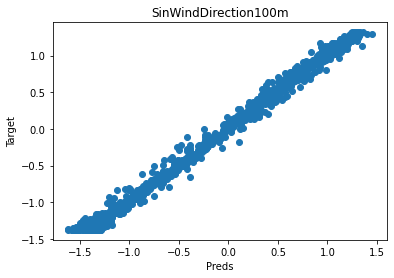

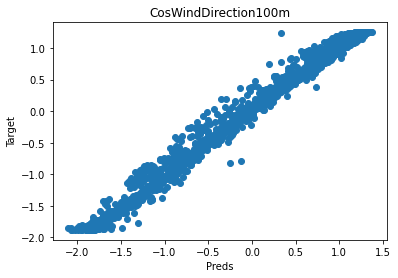

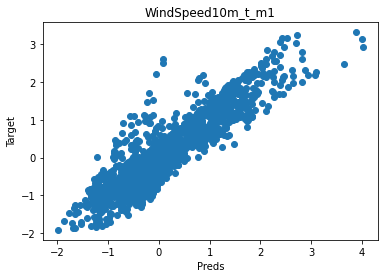

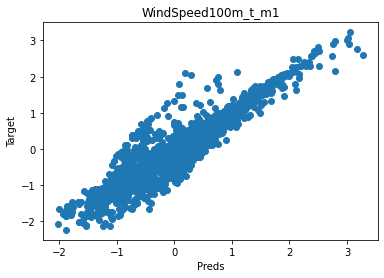

In [ ]:
preds, _ = learner.get_preds(ds_idx=1)
preds = pd.DataFrame(preds, columns=dls.valid_ds.cont_names, index=dls.valid_ds.items.index)

for col in preds.columns:
    plt.scatter(preds[col], dls.valid_ds.conts[col])
    plt.xlabel("Preds")
    plt.ylabel("Target")
    plt.title(col)
    plt.show()

In [ ]:
dls_regression = RenewableDataLoaders.from_df(df_train_single_task, 
                                   cat_names=cat_names, 
                                   cont_names=cont_names, 
                                   y_names="PowerGeneration",
                                   bs=24*30, 
                                   shuffle=True
                                  )

In [ ]:
freeze(learner.model)
unfreeze_n_final_layer(learner.model.encoder.layers, 1)
regression_model = AutoencoderForecast(learner.model, MultiLayerPerceptron([n_latent, n_latent*10,  1]))

In [ ]:
print_requires_grad(regression_model)

 (autoencoder): (
   (encoder): (
    (Identity())
    (ModuleList())
    (Dropout(p=0.0, inplace=False))
    (BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) Requires grad: False
     (layers): (
      Sequential (0): (
        (Linear(in_features=12, out_features=48, bias=False)) Requires grad: False
        (ReLU(inplace=True))
        (BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) Requires grad: False
      )
      Sequential (1): (
        (Linear(in_features=48, out_features=24, bias=False)) Requires grad: False
        (ReLU(inplace=True))
        (BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) Requires grad: False
      )
      Sequential (2): (
        (Linear(in_features=24, out_features=12, bias=False)) Requires grad: False
        (ReLU(inplace=True))
        (BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) Requires grad: False
      )
     

In [ ]:
learner_regression = Learner(dls_regression, regression_model, metrics=rmse)

In [ ]:
learner_regression.fit_one_cycle(50)

epoch,train_loss,valid_loss,_rmse,time
0,0.246683,0.213349,0.461897,00:00
1,0.242046,0.199875,0.447074,00:00
2,0.234337,0.186808,0.432213,00:00
3,0.223337,0.169448,0.411640,00:00
4,0.209670,0.147252,0.383734,00:00
5,0.194421,0.125164,0.353786,00:00
6,0.179687,0.108572,0.329503,00:00
7,0.165514,0.094240,0.306985,00:00
8,0.152270,0.083136,0.288333,00:00
9,0.139823,0.073274,0.270691,00:00


In [ ]:
preds, targets = learner_regression.get_preds(ds_idx=1)

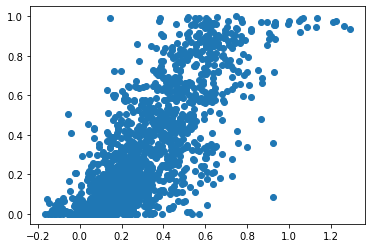

In [ ]:
plt.scatter(preds, targets)

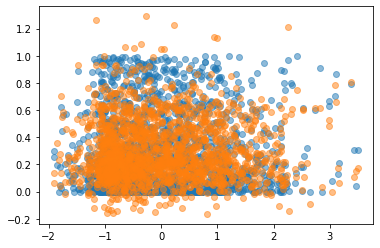

In [ ]:
plt.scatter(dls.valid_ds.conts.WindSpeed10m, targets, alpha=0.5)
plt.scatter(dls.valid_ds.conts.WindSpeed10m, preds, alpha=0.5)

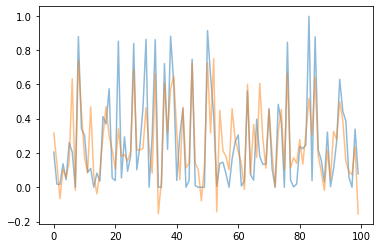

In [ ]:
plt.plot(targets[0:100], alpha=0.5)
plt.plot(preds[0:100], alpha=0.5)